# 0.2.3 - EDA: Feature Importance

**Overview**: This notebook is responsible for exploring the dataset. The purpose is to identify which features are most important for selecting the price range class.

**Actions**: This notebook performs the following actions:

- Fits a regression model on subset of training data for predicting price.
- Calculates feature importance for the regression model.

**Dependencies**: This notebook depends on the following artifact(s):

- `data/interim/ecommerce_data-cleaned-0.1.3.csv`

**Targets**: This notebook does not output any artifacts.

## Setup

The following cells import required libraries for python analysis, import the module path to access the project's `src/` module scripts, and enable autoreloading for the hot-reloading of source files outside of the notebook. These are all optional and should be included if needed for development.

In [1]:
# Enable hot-reloading of external scripts.
%load_ext autoreload
%autoreload 2

# Set project directory to project root.
from pathlib import Path
PROJECT_DIR = Path.cwd().resolve().parents[0]
%cd {PROJECT_DIR}

# Import utilities.
from src.data import *
from src.features import *

D:\Repositories\rit\ISTE780\Project


## Load Data

In [2]:
# Read dataset into pandas dataframe.
input_filepath = get_interim_filepath("0.1.3", tag="cleaned")
input_filepath

WindowsPath('D:/Repositories/rit/ISTE780/Project/data/interim/ecommerce_data-cleaned-0.1.3.csv')

In [3]:
# Reference: https://stackoverflow.com/questions/10867028/get-pandas-read-csv-to-read-empty-values-as-empty-string-instead-of-nan
# We should treat empty strings as empty instead of missing for this file.
df_input = pd.read_csv(input_filepath, index_col = 0, keep_default_na=False)
df_input.info()
df_input.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29604 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         29604 non-null  object 
 1   name          29604 non-null  object 
 2   description   29604 non-null  object 
 3   category_1    29604 non-null  object 
 4   category_2    29604 non-null  object 
 5   category_3    29604 non-null  object 
 6   keywords      29604 non-null  object 
 7   price_raw     29604 non-null  float64
 8   discount_raw  29604 non-null  float64
dtypes: float64(2), object(7)
memory usage: 2.3+ MB


,brand,name,description,category_1,category_2,category_3,keywords,price_raw,discount_raw
0,la cost,la costena chipotl pepper 7 oz pack 12,we aim show accur product inform manufactur su...,food,meal solut grain pasta,can good,can veget,31.93,31.93
1,equat,equat triamcinolon acetonid nasal allergi spra...,we aim show accur product inform manufactur su...,health,equat,equat allergi,equat sinu congest nasal care,10.48,10.48
2,adurosmart eria,adurosmart eria soft white smart a19 light bul...,we aim show accur product inform manufactur su...,electron,smart home,smart energi light,smart light smart light bulb,10.99,10.99
3,lowrid,24 classic adjust balloon fender set chrome bi...,we aim show accur product inform manufactur su...,sport outdoor,bike,bike accessori,bike fender,38.59,38.59
4,anself,eleph shape silicon drinkwar portabl silicon c...,we aim show accur product inform manufactur su...,babi,feed,sippi cup altern plastic,unknown,5.81,5.81


## Validation Subset

We split our data into appropriately sized train/test splits for validation.

In [4]:
from sklearn.model_selection import train_test_split

# Create a 50%/50% train-test split.
X = df_input.drop(columns=['price_raw', 'discount_raw'])
y = df_input['price_raw'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=100)

## Pipeline Creation

First we prepare our data for use within a learning model, encoding our text features appropriately.

In [5]:
# Function for creating the pipeline.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

def get_feature_transformer(columns, vectorizer):
    """Prepare the ColumnTransformer."""
    return ColumnTransformer([(feature, vectorizer, feature) for feature in columns], remainder = 'drop', verbose_feature_names_out=True)

vectorizer = TfidfVectorizer(stop_words="english", sublinear_tf=True, norm="l2")
column_transformer = get_feature_transformer(["brand", "name", "description", "category_1", "category_2", "category_3", "keywords"], vectorizer)
column_transformer

ColumnTransformer(transformers=[('brand',
                                 TfidfVectorizer(stop_words='english',
                                                 sublinear_tf=True),
                                 'brand'),
                                ('name',
                                 TfidfVectorizer(stop_words='english',
                                                 sublinear_tf=True),
                                 'name'),
                                ('description',
                                 TfidfVectorizer(stop_words='english',
                                                 sublinear_tf=True),
                                 'description'),
                                ('category_1',
                                 TfidfVectorizer(stop_words='english',
                                                 sublinear_tf=True),
                                 'category_1'),
                                ('category_2',
                                 

## Random Forest Regressor

Fit a `RandomForestRegressor` to determine feature importance based on mean decrease in impurity.

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2

# Save the feature names.
feature_names = list(X.columns)

# Compose pipeline for RandomForestClassifier.
clf_rf = Pipeline([('vect', column_transformer),
                   ('chi2', SelectKBest(chi2, k = 100)),
                   ('clf', RandomForestRegressor(random_state=100))])

In [7]:
%%time

# Fit the model.
print("Fitting the RandomForestRegressor...")
clf_rf.fit(X_train, y_train)

Fitting the RandomForestRegressor...
Wall time: 3.15 s


Pipeline(steps=[('vect',
                 ColumnTransformer(transformers=[('brand',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'brand'),
                                                 ('name',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'name'),
                                                 ('description',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'description'),
                                                 ('category_1',
                      

In [8]:
%%time

import numpy as np

# Calculate importances.
print("Calculating feature importances...")
importances = clf_rf.named_steps['clf'].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.named_steps['clf'].estimators_], axis=0)

Calculating feature importances...
Wall time: 8.99 ms


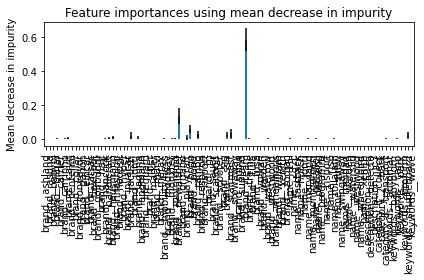

In [9]:
# Plotting the impurity-based importance.
import matplotlib.pyplot as plt

feature_names = clf_rf.named_steps['vect'].get_feature_names_out()[clf_rf.named_steps['chi2'].get_support()]
forest_importances = pd.Series(importances, index = feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = std, ax = ax)
ax.set_title("Feature importances using mean decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()